In [1]:
%pylab
%matplotlib inline
import pandas as pd
import numpy as np
from numba import jit
from scipy import stats
from scipy.stats import spearmanr, entropy
%config InlineBackend.figure_format = 'svg'
import glob

from IPython.core.debugger import Pdb

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


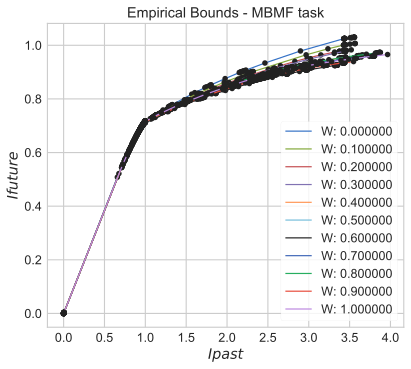

In [2]:
hull_names = sort(glob.glob('./MBMF_bounds/*.npy'))

hulls = {}
for i,key in enumerate(np.arange(0.0,1.1,.1)):
#     if i%2 == 0:
    if True:
        hulls[key] = np.load(hull_names[i])
        hull = hulls[key]
        plot(hull[:-1,0],hull[:-1,1],'-',label='W: %f'%key)
        plot(hull[:-1,0],hull[:-1,1],'ok')
xlabel('$Ipast$')
ylabel('$Ifuture$')
title('Empirical Bounds - MBMF task')
legend()

In [7]:
hulls

{0.0: array([[3.55992895e+00, 1.02992500e+00],
        [3.55905937e+00, 1.02989474e+00],
        [3.55817808e+00, 1.02986401e+00],
        [3.55352751e+00, 1.02970085e+00],
        [3.55301262e+00, 1.02968268e+00],
        [3.55161259e+00, 1.02963319e+00],
        [3.55063184e+00, 1.02959842e+00],
        [3.55017515e+00, 1.02958222e+00],
        [3.52785416e+00, 1.02877123e+00],
        [3.52538584e+00, 1.02867900e+00],
        [3.52440102e+00, 1.02864218e+00],
        [3.50625260e+00, 1.02794938e+00],
        [3.44367884e+00, 1.02534015e+00],
        [3.43985104e+00, 1.02517908e+00],
        [3.43853065e+00, 1.02512058e+00],
        [3.43844614e+00, 1.02511679e+00],
        [3.43827477e+00, 1.02510910e+00],
        [3.43801452e+00, 1.02509735e+00],
        [3.43746535e+00, 1.02507248e+00],
        [3.43737083e+00, 1.02506818e+00],
        [3.43727542e+00, 1.02506383e+00],
        [3.43688485e+00, 1.02504598e+00],
        [3.43678491e+00, 1.02504140e+00],
        [3.43668405e+00, 1.02

In [3]:
def trial_label(x):
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)

def make_features(trials_data):
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi

def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' Function to calculate distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound - higher 
    return p_ifuture - ((p_ipast*slp)+intercept)

In [35]:
#Load data
read_data = np.load('data/DAW_DATA_FOR_CLUSTER.npy').item()

predInfo_raw = {}
predInfo_norm = {}
dbound_raw = {}
dbound_norm = {}
sat = {}
figure(1)
for w in np.sort(list(read_data.keys())):
    print('Computing pred info %f...'%w)
    subject = read_data[w]
    keys = ['S2', 'R1', 'R2', 'Rw', 'best_R1']
    trials = np.vstack([subject[key] for key in keys])
    features = make_features(trials)
    resp = subject['R1']
    
    #Saturation point (mutual info between past and future feature)
    sat[w] = mutual_inf(features[:-1],features[1:])
    
    #Ipast and Ifuture
    predInfo_raw[w] = [mutual_inf(features[:-1],resp[1:]),mutual_inf(features[1:],resp[:-1])]
    predInfo_norm[w] = predInfo_raw[w]/sat[w]
    


    #Bound
    hull = hulls[w]
    dbound_raw[w] = deltaBound(np.flip(hull[:-1,0],0),np.flip(hull[:-1,1],0),predInfo_raw[w][0],predInfo_raw[w][1])
    hull_norm = hull/sat[w]
    print(predInfo_raw[w])
    dbound_norm[w] = deltaBound(np.flip(hull_norm[:-1,0],0),np.flip(hull_norm[:-1,1],0),predInfo_norm[w][0],predInfo_norm[w][1])
    
    #Plot
#     plot(predInfo[w][0],dbound[w],'o',label='W: %f'%w)
# ylabel('Distance from Bound')
# xlabel('Ipast')
# legend()




Computing pred info 0.000000...


/Users/alsfilip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


[0.12255645876499133, 0.06875495850380652]
Computing pred info 0.100000...
[0.09821772742720582, 0.05700164439998327]
Computing pred info 0.200000...
[0.08090663565133607, 0.045663582150512326]
Computing pred info 0.300000...
[0.06837712835972815, 0.02975499147048883]
Computing pred info 0.400000...
[0.05600049864417946, 0.024059850704018514]
Computing pred info 0.500000...
[0.04393639872247295, 0.015147956998023722]
Computing pred info 0.600000...
[0.040942761382920294, 0.012425629076625734]
Computing pred info 0.700000...
[0.038161157795140344, 0.011912858764141335]
Computing pred info 0.800000...
[0.048735524949561994, 0.01579229561583523]
Computing pred info 0.900000...
[0.04007115340885149, 0.010165225894991171]
Computing pred info 1.000000...
[0.0399516632559717, 0.010299905736471751]


<Figure size 460.8x403.2 with 0 Axes>

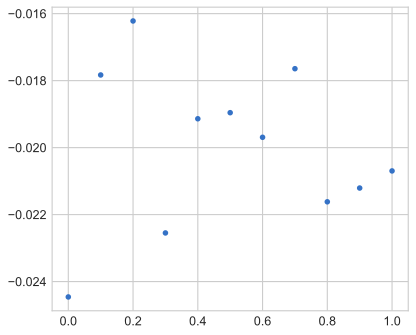

In [38]:
ws = dbound_norm.keys()
db = [dbound_norm[key] for key in ws]
ip = [predInfo_norm[key][0] for key in ws]

plot(ws,db,'o')

ValueError: num must be 1 <= num <= 10, not 11

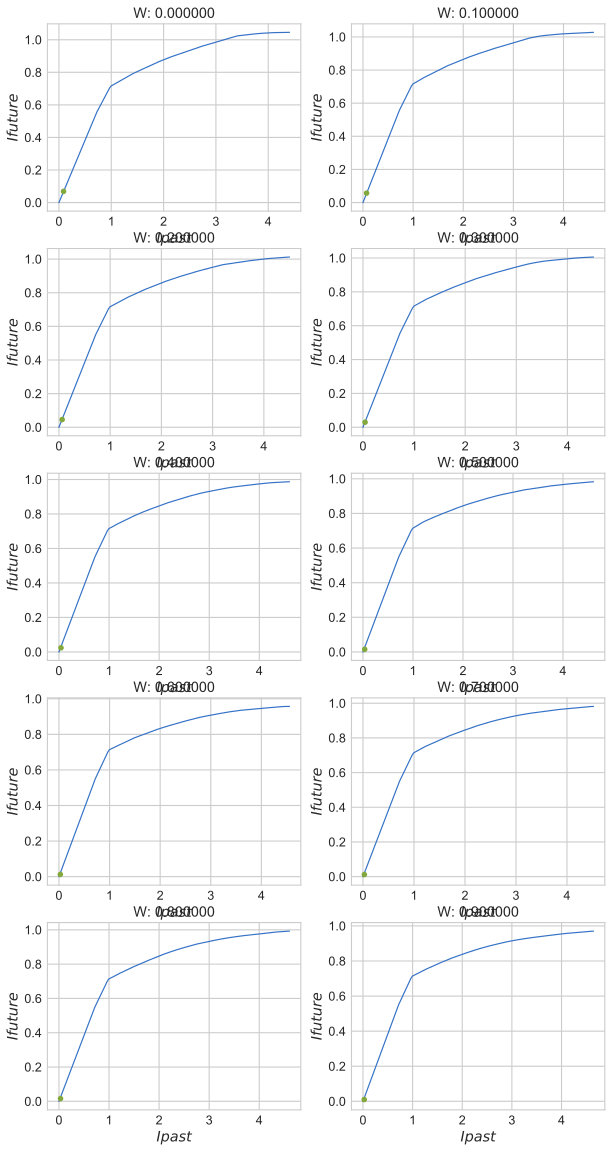

In [28]:
figure(2,figsize(10,20))
for i,key in enumerate(np.sort(list(read_data.keys()))):
    subplot(5,2,i+1)
    hulls[key] = np.load(hull_names[i])
    hull = hulls[key]
    plot(hull[:-1,0],hull[:-1,1],'-')
    plot(predInfo[key][0],predInfo[key][1],'o')
    xlabel('$Ipast$')
    ylabel('$Ifuture$')
    title('W: %f'%key)

AxisError: axis -1 is out of bounds for array of dimension 0